In [37]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

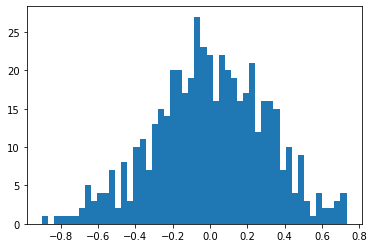

In [38]:
# https://stackoverflow.com/questions/36894191/how-to-get-a-normal-distribution-within-a-range-in-numpy
def get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1):
    return truncnorm(
        (low - mean)/sd, 
        (upp - mean)/sd, 
        loc = mean, 
        scale = sd)

X = get_truncated_normal()
plt.hist(X.rvs(500), bins = 50)
plt.show()

In [39]:
class post:
    
    def __init__(self, user_id, kind, user_ideology, user_trust):
        self.type = kind   # binary: either post (1) or comment (0)
        self.author = user_id
        
        # post's ideology score
        self.ideology = get_truncated_normal(mean=user_ideology, sd=0.2, low=-1, upp=1).rvs()  
        
        # post's trustworthiness
        self.trust = get_truncated_normal(mean=user_trust, sd=0.1, low=0, upp=1).rvs()  

In [40]:
class user:
    def __init__(self):
        self.ideology = get_truncated_normal(mean=0, sd=0.3, low=-1, upp=1).rvs()
        # care value is dependent on the absolute value of ideology value of the user + noise,
        # on the assumption based on research that reveals people with more radial political leanings tend to be more engaging
        self.care = get_truncated_normal(mean=abs(self.ideology), sd = 0.15, low = 0, upp=1).rvs()
        self.trust = get_truncated_normal(mean=0.5, sd=0.15, low=0, upp=1).rvs()   # post's trustworthiness
        
        # in a number of iterations, if the user reads more than this percentage of posts which ideology distance 
        #   between the user and the post is more than 1.2, the user will quit using the platform
        self.tolerance = 1 - self.care
        # the number of "bad" post that the user hate (ideology distance > 1.2) 
        #   that will make the user leave the platform 
        self.bad_posts = 0
        self.max_bad_posts = 10
        
        # how many posts the user has read
        self.num_posts_read = 0
        
        # how easy a user will be influenced/persuaded by a post, which is determined by the ideology, where
        #   a right-wing user will be more difficult to influence than a left-wing user
        if(self.ideology < 0.5):
            self.easiness = get_truncated_normal(mean=0.5, sd = 0.15, low = 0, upp=1).rvs()
        else:
            self.easiness = get_truncated_normal(mean=0.25, sd = 0.15, low = 0, upp=1).rvs()
        
def create_n_users (n):
    user_list = []
    for i in range(n):
        user_list.append(user())
    return user_list

In [41]:
def create_posts(users):
    post_list = []
    for j in range(len(users)):
        user = users[j]
        num_posts = int(round((abs(user.ideology)*10)+(user.care*10), 0))
        for i in range(num_posts):
            post_list.append(post(j, 1, user.ideology, user.trust))
        #print(num_posts, user.care, user.ideology)
    return post_list

#user_list = create_n_users(100)
#post_list = create_posts(user_list)

#user_idx = 0
#for i in range(len(user_list)):
  #print("===== User", i, "=====")
  #num_posts = int(round((abs(user_list[i].ideology)*10)+(user_list[i].care*10), 0))
  #print("user's ideology score: ", user_list[i].ideology, ", user's care score: ", user_list[i].care, "# posts:", num_posts)

  #for j in range(num_posts):
  #  post_list.append(post(i, 1, user_list[i].ideology, user_list[i].trust))
  #  print("post", j, ": author =", post_list[-1].author, 
  #        ", post's ideology score =", post_list[-1].ideology, 
  #        ", post's trust score =", post_list[-1].trust)
  
  #print()

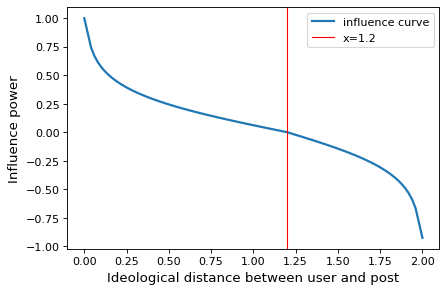

In [20]:
import math

# cutoff_point: when the ideology distance is greater than 1+notwork_point,
#   the user's ideology will be pulled further away from the post's ideology
# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def logit(x, cutoff_pt=1.2, offset_power=2):
    if(x == 0):
        x = x+10**(-offset_power)
    elif(x == 2):
        x = x-10**(-offset_power)
        
    if(x <= cutoff_pt):
        x = (x/cutoff_pt)/2
    else:
        x = (((x-cutoff_pt)/(2-cutoff_pt))+1)/2
    
    return -math.log(x/(1-x))

# I use the formula below to make the influence effect between -1 and 1.
#   ref: https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
def normalize(value):
    max_value = logit(0)
    #min_value = logit(2)
    min_value = -max_value
    
    return_value = 2*((logit(value) - min_value)/(max_value - min_value)) -1
    if(return_value > 1):
        return 1
    elif(return_value < -1):
        return -1
    else:
        return return_value

# calculate how each post the user has read will affect the user's ideology
# - the affect power is inverse proportional to the distance between the user's and the post's ideology
# - use user's easiness parameter (between 0 and 1) to tune the influence effect  
# return value: new user ideology score
def influence(user, post, tune_power=1.1, tune_denominator=0.1):
    ideology_distance = abs(user.ideology - post.ideology)
    influence_ratio = user.easiness * normalize(ideology_distance)
    new_user_ideology = user.ideology - influence_ratio*(user.ideology - post.ideology)
    return new_user_ideology

# for testing purpose
x = []
for i in range(101):
    x.append(i*2/100)
    
y = []
for i in range(101):
    y.append(normalize(x[i]))

plt.figure(figsize=(6, 4), dpi=80)
plt.xlabel("Ideological distance between user and post", fontsize=12)
plt.ylabel("Influence power", fontsize=12)
plt.plot(x, y, linewidth=2.0, label="influence curve")
plt.axvline(x=1.2, color="red", linewidth=1.0, label="x=1.2")
plt.legend()

#print(user_list[0].ideology, 
#      post_list[0].ideology, 
#      abs(user_list[0].ideology - post_list[0].ideology),
#      user_list[0].easiness)
#print(influence(user_list[0], post_list[0]))
#print(normalize(0.5))

In [59]:
def recommend_n_by_user_post (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
        result = list(new_diff.keys())
        new_result = []
        for i in range(n):
            new_result.append(result[i])
        recommended_posts[user] = new_result
        index += 1
    return recommended_posts

In [61]:
def recommend_n_random (posts, users, n):
    user_post = {}
    index = 0
    for user in users:
        if user not in user_post.keys():
            user_post[user] = []
            while len(user_post[user]) < n:
                r = random.choice(posts)
                if not r.author == index:
                    user_post[user].append(r)
        index += 1
    return user_post

In [83]:
def recommend_n_opposite (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
        new_diff_1 = list(new_diff.keys())
        result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
        new_result = []
        for i in range(n):
            new_result.append(result[len(result) - 1 - i])
        recommended_posts[user] = new_result
        index += 1
    return recommended_posts

In [96]:
def recommend_n_accordingly (posts, users, n):
    #aggregate each post.ideology by users
    user_all_posts = {}
    for post in posts:
        if post.author not in user_all_posts.keys():
            user_all_posts[post.author] = []
        user_all_posts[post.author].append(post.ideology)
    
    #populate the user - ideology mean dictionary
    user_ideology_from_posts = {}
    index = 0
    for user in users:
        if index in user_all_posts.keys():
            user_ideology_from_posts[user] = sum(user_all_posts[index])/len(user_all_posts[index])
        else:
            user_ideology_from_posts[user] = 0
        index += 1
   
    recommended_posts = {}
    index = 0
    for user in users:
        diff = {}
        for post in posts:
            if not post.author == index:
                diff[post] = abs(user_ideology_from_posts[user] - post.ideology)
        user_val = abs(user_ideology_from_posts[user])
        if user_val < 1/3:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            result = list(new_diff.keys())
            new_result = []
            for i in range(n):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        elif user_val < 2/3:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            result = list(new_diff.keys())
            new_result = []
            for i in range(int(n/2)):
                new_result.append(result[i])
            new_diff_1 = list(new_diff.keys())
            result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
            for i in range(n - int(n/2)):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        else:
            new_diff = dict(sorted(diff.items(), key = lambda item: item[1]))
            new_diff_1 = list(new_diff.keys())
            result = list(filter(lambda x : x.ideology * user_ideology_from_posts[user] <= 0, new_diff_1))
            for i in range(n):
                new_result.append(result[i])
            recommended_posts[user] = new_result
        index += 1
    return recommended_posts

In [10]:
#def run_simulation(num_iterations):
num_iterations = 100

# Generate users for the simulation
users_list = create_n_users(100)

original_user_ideology_list = []
for cur_user in users_list:
    original_user_ideology_list.append(cur_user.ideology)

recommended_posts = {}
for i in range(num_iterations):
    # Generate posts for this iteration based on list of users  
    posts_list = create_posts(users_list)
    # Recommend posts to each user
    recommended_posts = recommend_n_by_user_post(posts_list, users_list, 5)

    new_user_ideology_list = []
    j = 0
    while j < len(users_list):
    #for j in range(len(users_list)):
        for recommended_post in recommended_posts[j]:
            ideo_distance = abs(users_list[j].ideology - recommended_post.ideology)
            if(ideo_distance >= 1.2):
                users_list[j].bad_posts += 1
            
            users_list[j].ideology = influence(users_list[j], recommended_post)
            users_list[j].num_posts_read += 1

        if ((users_list[j].bad_posts == users_list[j].max_bad_posts) and 
            (users_list[j].bad_posts/users_list[j].num_posts_read > users_list[j].tolerance)):
            print("User %j has left (user's tolerance score = %f; the user has read %d posts)." 
                  % (j, users_list[j].tolerance, users_list[j].num_posts_read))
            users_lists.pop(j)
        else:
            new_user_ideology_list.append(users_list[j].ideology)
            j += 1
        
#return recommended_posts
#recommended_posts = run_simulation(100)

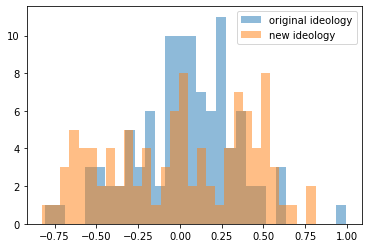

In [11]:
#bins = np.linspace(-1, 1, 100)
plt.hist(original_user_ideology_list, 30, alpha=0.5, label='original ideology')
plt.hist(new_user_ideology_list, 30, alpha=0.5, label='new ideology')    
plt.legend(loc='upper right')
plt.show()

In [43]:
u_list = create_n_users(100)
p_list = create_posts(u_list)

In [98]:
rec_1 = recommend_n_accordingly(p_list, u_list, 5)
for user in rec_1.keys():
    print(user.ideology)
    print("\n")
    for post in rec_1[user]:
        print(post.ideology)
    print("\n")

-0.4362919142366657


-0.44966791268705175
-0.4477988811306515
0.0005817446822996564
0.00883169799895328
0.013608861681392012


-0.12300162232986736


-0.17479416249891602
-0.16824209021403902
-0.16527560164072877
-0.181244074972279
-0.18209928877194104


-0.040463390096783416


0.1537356822692664
0.1525555181160284
0.15754864511831518
0.16046990771466318
0.14706975770116565


0.36970906781821467


0.3917735912410961
0.37961948582394484
-0.0023434477002212406
-0.005796602833072758
-0.008304905071701181


0.26569218343557666


0.31504017485454217
0.29935988845366507
0.2988704575013372
0.3162315954802619
0.29219562074350564


0.14645944816175435


0.18608778252090533
0.17797109190267868
0.18708613264745166
0.187606375916963
0.1760392470663456


0.3259252422927355


0.4104983972415275
0.4080775394897067
-0.0023434477002212406
-0.005796602833072758
-0.008304905071701181


-0.06320081710778372


-0.3943894312537506
-0.3962207247498795
0.0005817446822996564
0.00883169799895328
0.013608861681